In [1]:
%reload_ext autoreload
%autoreload 2


import os, random, datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import Image

In [2]:
from nerfmm.utils.pos_enc import encode_position
from nerfmm.utils.volume_op import volume_rendering, volume_sampling_ndc
from nerfmm.utils.comp_ray_dir import comp_ray_dir_cam_fxfy

# utlities
from nerfmm.utils.training_utils import mse2psnr
from nerfmm.utils.lie_group_helper import convert3x4_4x4

In [3]:
from gradslam.datasets.tum import TUM

root_dir = "/scratch/saksham/data/tum/"
dataset = TUM(root_dir, sequences = ("../sequences.txt"), seqlen = 30)
colors, depths, intrinsics, poses, transforms, names, timestamps = dataset[0]


image_data = {
    "imgs": colors,
    "img_names" : names,
    "N_imgs" : colors.shape[0],
    "H" : colors.shape[1],
    "W" : colors.shape[2],
    "poses" : poses
}

Loaded 30 imgs, resolution 480 x 640
torch.Size([30, 480, 640, 3])


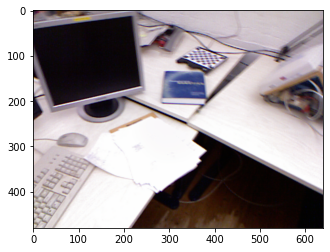

In [4]:
imgs = image_data['imgs'] 

N_IMGS = image_data['N_imgs']
H = image_data['H']
W = image_data['W']

print('Loaded {0} imgs, resolution {1} x {2}'.format(N_IMGS, H, W))
print(imgs.shape)
plt.imshow(imgs[0].long())

In [5]:
class TinyNerf(nn.Module):
    def __init__(self, pos_in_dims, dir_in_dims, D):
        """
        :param pos_in_dims: scalar, number of channels of encoded positions
        :param dir_in_dims: scalar, number of channels of encoded directions
        :param D:           scalar, number of hidden dimensions
        """
        super(TinyNerf, self).__init__()

        self.pos_in_dims = pos_in_dims
        self.dir_in_dims = dir_in_dims

        self.layers0 = nn.Sequential(
            nn.Linear(pos_in_dims, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
        )

        self.fc_density = nn.Linear(D, 1)
        self.fc_feature = nn.Linear(D, D)
        self.rgb_layers = nn.Sequential(nn.Linear(D + dir_in_dims, D//2), nn.ReLU())
        self.fc_rgb = nn.Linear(D//2, 3)

        self.fc_density.bias.data = torch.tensor([0.1]).float()
        self.fc_rgb.bias.data = torch.tensor([0.02, 0.02, 0.02]).float()

    def forward(self, pos_enc, dir_enc):
        """
        :param pos_enc: (H, W, N_sample, pos_in_dims) encoded positions
        :param dir_enc: (H, W, N_sample, dir_in_dims) encoded directions
        :return: rgb_density (H, W, N_sample, 4)
        """
        x = self.layers0(pos_enc)  # (H, W, N_sample, D)
        density = self.fc_density(x)  # (H, W, N_sample, 1)

        feat = self.fc_feature(x)  # (H, W, N_sample, D)
        x = torch.cat([feat, dir_enc], dim=3)  # (H, W, N_sample, D+dir_in_dims)
        x = self.rgb_layers(x)  # (H, W, N_sample, D/2)
        rgb = self.fc_rgb(x)  # (H, W, N_sample, 3)

        rgb_den = torch.cat([rgb, density], dim=3)  # (H, W, N_sample, 4)
        return rgb_den

In [6]:
class RayParameters():
    def __init__(self):
      self.NEAR, self.FAR = 0.0, 1.0  # ndc near far
      self.N_SAMPLE = 128  # samples per ray
      self.POS_ENC_FREQ = 10  # positional encoding freq for location
      self.DIR_ENC_FREQ = 4   # positional encoding freq for direction

ray_params = RayParameters()

In [7]:
def model_render_image(c2w, rays_cam, t_vals, ray_params, H, W, fxfy, nerf_model,
                       perturb_t, sigma_noise_std):
    """
    :param c2w:         (4, 4)                  pose to transform ray direction from cam to world.
    :param rays_cam:    (someH, someW, 3)       ray directions in camera coordinate, can be random selected
                                                rows and cols, or some full rows, or an entire image.
    :param t_vals:      (N_samples)             sample depth along a ray.
    :param perturb_t:   True/False              perturb t values.
    :param sigma_noise_std: float               add noise to raw density predictions (sigma).
    :return:            (someH, someW, 3)       volume rendered images for the input rays.
    """
    # KEY 2: sample the 3D volume using estimated poses and intrinsics online.
    # (H, W, N_sample, 3), (H, W, 3), (H, W, N_sam)
    sample_pos, _, ray_dir_world, t_vals_noisy = volume_sampling_ndc(c2w, rays_cam, t_vals, ray_params.NEAR,
                                                                     ray_params.FAR, H, W, fxfy, perturb_t)

    # encode position: (H, W, N_sample, (2L+1)*C = 63)
    pos_enc = encode_position(sample_pos, levels=ray_params.POS_ENC_FREQ, inc_input=True)

    # encode direction: (H, W, N_sample, (2L+1)*C = 27)
    ray_dir_world = F.normalize(ray_dir_world, p=2, dim=2)  # (H, W, 3)
    dir_enc = encode_position(ray_dir_world, levels=ray_params.DIR_ENC_FREQ, inc_input=True)  # (H, W, 27)
    dir_enc = dir_enc.unsqueeze(2).expand(-1, -1, ray_params.N_SAMPLE, -1)  # (H, W, N_sample, 27)

    # inference rgb and density using position and direction encoding.
    rgb_density = nerf_model(pos_enc, dir_enc)  # (H, W, N_sample, 4)

    render_result = volume_rendering(rgb_density, t_vals_noisy, sigma_noise_std, rgb_act_fn=torch.sigmoid)
    rgb_rendered = render_result['rgb']  # (H, W, 3)
    depth_map = render_result['depth_map']  # (H, W)

    result = {
        'rgb': rgb_rendered,  # (H, W, 3)
        'depth_map': depth_map,  # (H, W)
    }

    return result

In [11]:
def train_one_epoch(imgs, H, W, ray_params, opt_nerf, nerf_model):
    nerf_model.train()

    t_vals = torch.linspace(ray_params.NEAR, ray_params.FAR, ray_params.N_SAMPLE, device='cuda')  # (N_sample,) sample position
    L2_loss_epoch = []

    # shuffle the training imgs
    ids = np.arange(N_IMGS)
    np.random.shuffle(ids)

    for i in ids:
        fxfy = (525*(W/640), 525*(H/480))

        # KEY 1: compute ray directions using estimated intrinsics online.
        ray_dir_cam = comp_ray_dir_cam_fxfy(H, W, fxfy[0], fxfy[1])
        try:
            img = imgs[i].cuda()  # (H, W, 4)
        except:
            breakpoint()
        c2w = poses[i].cuda()  # (4, 4)

        # sample 32x32 pixel on an image and their rays for training.
        r_id = torch.randperm(H, device='cuda')[:32]  # (N_select_rows)
        c_id = torch.randperm(W, device='cuda')[:32]  # (N_select_cols)
        ray_selected_cam = ray_dir_cam[r_id][:, c_id]  # (N_select_rows, N_select_cols, 3)
        img_selected = img[r_id][:, c_id]  # (N_select_rows, N_select_cols, 3)

        # render an image using selected rays, pose, sample intervals, and the network
        render_result = model_render_image(c2w, ray_selected_cam, t_vals, ray_params,
                                           H, W, fxfy, nerf_model, perturb_t=True, sigma_noise_std=0.0)
        rgb_rendered = render_result['rgb']  # (N_select_rows, N_select_cols, 3)
        L2_loss = F.mse_loss(rgb_rendered, img_selected)  # loss for one image

        L2_loss.backward()
        opt_nerf.step()
        opt_nerf.zero_grad()

        L2_loss_epoch.append(L2_loss)

    L2_loss_epoch_mean = torch.stack(L2_loss_epoch).mean().item()
    return L2_loss_epoch_mean

In [12]:
def render_novel_view(c2w, H, W, fxfy, ray_params, nerf_model):
    nerf_model.eval()

    fxfy = (525*(W/640), 525*(H/480))
    ray_dir_cam = comp_ray_dir_cam_fxfy(H, W, fxfy[0], fxfy[1])
    t_vals = torch.linspace(ray_params.NEAR, ray_params.FAR, ray_params.N_SAMPLE, device='cuda')  # (N_sample,) sample position

    c2w = c2w.to('cuda')  # (4, 4)

    # split an image to rows when the input image resolution is high
    rays_dir_cam_split_rows = ray_dir_cam.split(10, dim=0)  # input 10 rows each time
    rendered_img = []
    rendered_depth = []
    for rays_dir_rows in rays_dir_cam_split_rows:
        render_result = model_render_image(c2w, rays_dir_rows, t_vals, ray_params,
                                           H, W, fxfy, nerf_model,
                                           perturb_t=False, sigma_noise_std=0.0)
        rgb_rendered_rows = render_result['rgb']  # (num_rows_eval_img, W, 3)
        depth_map = render_result['depth_map']  # (num_rows_eval_img, W)

        rendered_img.append(rgb_rendered_rows)
        rendered_depth.append(depth_map)

    # combine rows to an image
    rendered_img = torch.cat(rendered_img, dim=0)  # (H, W, 3)
    rendered_depth = torch.cat(rendered_depth, dim=0)  # (H, W)
    return rendered_img, rendered_depth

In [14]:
scene_name = "tum_small"

N_EPOCH = 200  # set to 1000 to get slightly better results. we use 10K epoch in our paper.
EVAL_INTERVAL = 50  # render an image to visualise for every this interval.

# Get a tiny NeRF model. Hidden dimension set to 128
nerf_model = TinyNerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

# Set lr and scheduler: these are just stair-case exponantial decay lr schedulers.
opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import MultiStepLR
scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)

# Set tensorboard writer
writer = SummaryWriter(log_dir=os.path.join('../logs', scene_name, str(datetime.datetime.now().strftime('%y%m%d_%H%M%S'))))

pose_history = []
# Training
print('Training... Check results in the tensorboard above.')
for epoch_i in tqdm(range(N_EPOCH), desc='Training'):
    L2_loss = train_one_epoch(imgs, H, W, ray_params, opt_nerf, nerf_model)
    train_psnr = mse2psnr(L2_loss)

    writer.add_scalar('train/psnr', train_psnr, epoch_i)

    fxfy = (525*(W/640), 525*(H/480))
    print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

    scheduler_nerf.step()

    learned_c2ws = poses
    pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we vis in 2D.

    with torch.no_grad():
        if (epoch_i+1) % EVAL_INTERVAL == 0:
            eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
            fxfy = (525*(W/640), 525*(H/480))
            rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)
            writer.add_image('eval/img', rendered_img.permute(2, 0, 1), global_step=epoch_i)
            writer.add_image('eval/depth', rendered_depth.unsqueeze(0), global_step=epoch_i)

pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
print('Training finished.')

Training... Check results in the tensorboard above.


epoch    0 Training PSNR -44.443, estimated fx 525.0 fy 525.0
epoch    1 Training PSNR -44.429, estimated fx 525.0 fy 525.0
epoch    2 Training PSNR -44.497, estimated fx 525.0 fy 525.0
epoch    3 Training PSNR -44.478, estimated fx 525.0 fy 525.0
epoch    4 Training PSNR -44.560, estimated fx 525.0 fy 525.0
epoch    5 Training PSNR -44.523, estimated fx 525.0 fy 525.0
epoch    6 Training PSNR -44.605, estimated fx 525.0 fy 525.0
epoch    7 Training PSNR -44.488, estimated fx 525.0 fy 525.0
epoch    8 Training PSNR -44.413, estimated fx 525.0 fy 525.0
epoch    9 Training PSNR -44.597, estimated fx 525.0 fy 525.0
epoch   10 Training PSNR -44.527, estimated fx 525.0 fy 525.0
epoch   11 Training PSNR -44.547, estimated fx 525.0 fy 525.0
epoch   12 Training PSNR -44.709, estimated fx 525.0 fy 525.0
epoch   13 Training PSNR -44.527, estimated fx 525.0 fy 525.0
epoch   14 Training PSNR -44.578, estimated fx 525.0 fy 525.0
epoch   15 Training PSNR -44.539, estimated fx 525.0 fy 525.0
epoch   